# Modeling an Autoregressive Process

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Predicting the average weekly foot traffic in a retail store

#### Gather Data

In [5]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/foot_traffic.csv')

df = pd.read_csv(url1)

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


#### Plot Data

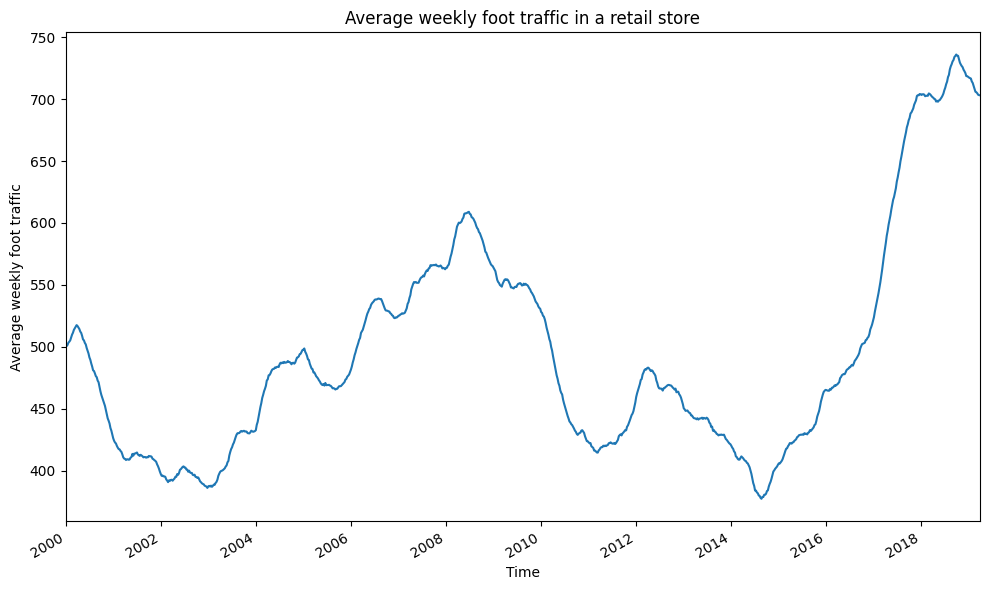

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
ax.set_title('Average weekly foot traffic in a retail store')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

#### ADF Test

In [9]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['foot_traffic'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.1758885999240787
p-value: 0.6838808917896172

p-value > alpha; H0: Not Stationary


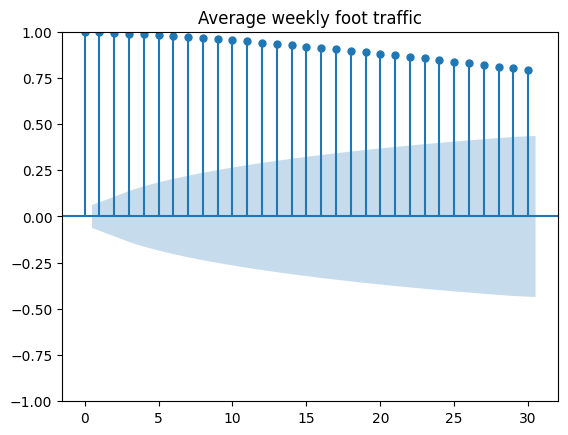

In [10]:
# Plot Auto Correlation Function
plot_acf(df['foot_traffic'], lags=30);

plt.title('Average weekly foot traffic')

plt.show()

#### Apply a transformation to make it stationary

In [12]:
# Apply a first-order differencing on the data

foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

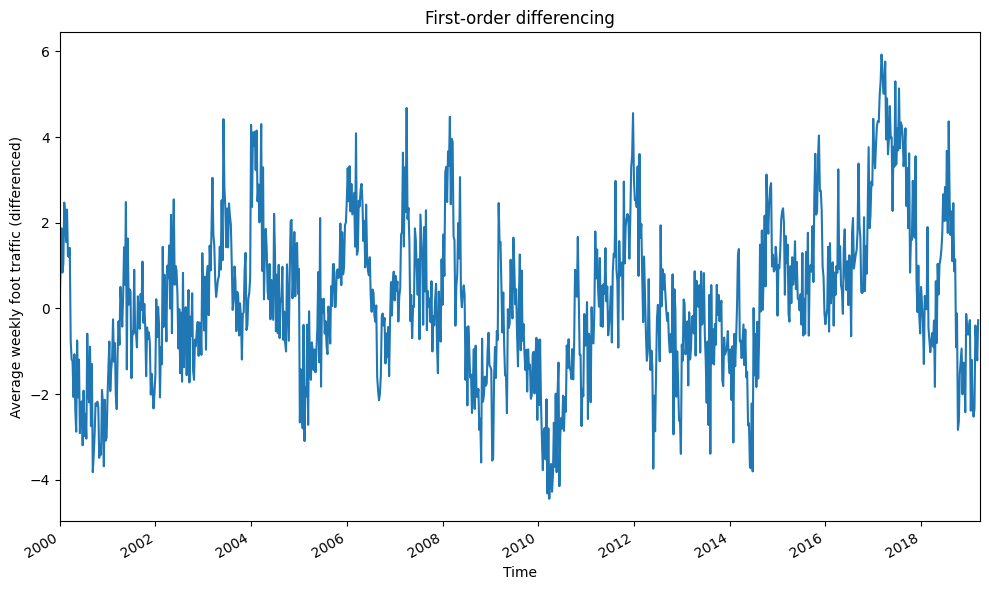

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')
ax.set_title('First-order differencing')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

*Differenced average weekly foot traffic at a retail store. Notice that the trend effect has been removed, since the series starts and ends at roughly the same value.*

#### ADF Test on transformation 

In [16]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result1 = adfuller(foot_traffic_diff)

# Display ADF test result
print(f"ADF Statistic: {adf_result1[0]}")
print(f"p-value: {adf_result1[1]}")
print()

if adf_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -5.2682313474220335
p-value: 6.3693176547816065e-06

p-value < alpha; Ha: Stationary


#### Plot ACF on transformation

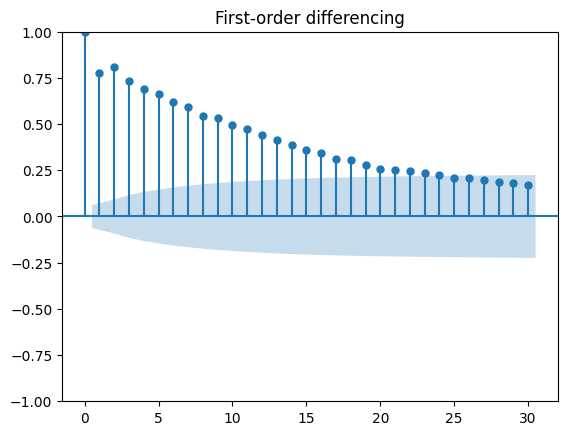

In [18]:
# Plot Auto Correlation Function
plot_acf(foot_traffic_diff, lags=30);

plt.title('First-order differencing')

plt.show()

*ACF plot of the differenced average weekly foot traffic at a retail store.
Notice how the plot is slowly decaying. This is a behavior that we have not observed
before, and it is indicative of an autoregressive process.*

### The Partial AutoCorrelation Function (PACF)

    Partial autocorrelation measures the correlation between lagged values in a time
    series when we remove the influence of correlated lagged values in between. We can
    plot the partial autocorrelation function to determine the order of a stationary AR(p)
    process. The coefficients will be non-significant after lag p.

##### Simulation:

$$
y_t = 0.33 * y_{t-1} + 0.50 * y_{t-2}
$$

In [23]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)   # It will simulate the AR(2)

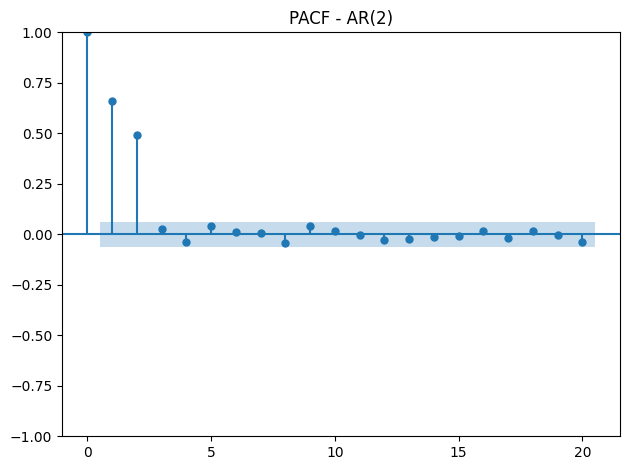

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.title('PACF - AR(2)')

plt.tight_layout()

*It shows that we have an autoregressive process of order 2.*

The partial autocorrelation coefficients are not significantly different from 0. Therefore, we can identify the order of a stationary AR(p) model using the PACF plot.

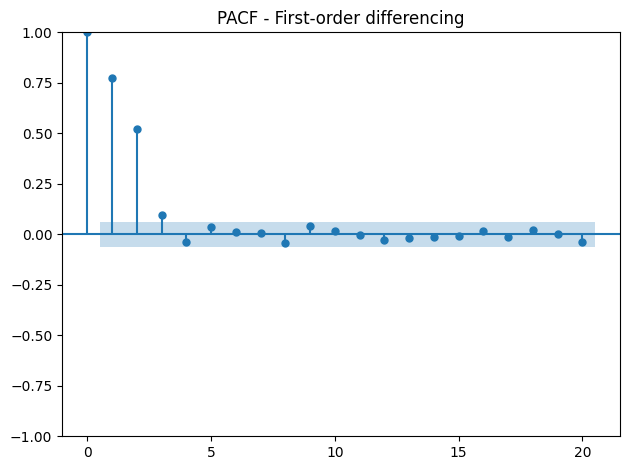

In [27]:
plot_pacf(foot_traffic_diff, lags=20);

plt.title('PACF - First-order differencing')

plt.tight_layout()

*The PACF of our differenced average weekly foot traffic in a retail
store. You can see that the coefficients are non-significant after lag 3.
Therefore, we can say that our stationary process is a third-order
autoregressive process, or an AR(3) process.*

We will forecast next week’s average foot traffic in a retail store using the same
dataset we have been working with. In order to evaluate our forecasts, we will hold out
the last 52 weeks of data for our test set, while the rest will be used for training. That
way, we can evaluate the performance of our forecast over a period of 1 year.

In [30]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]  # All data less the 52 last weeks
test = df_diff[-52:]   # Last 52 weeks

print(len(train))
print(len(test))

947
52


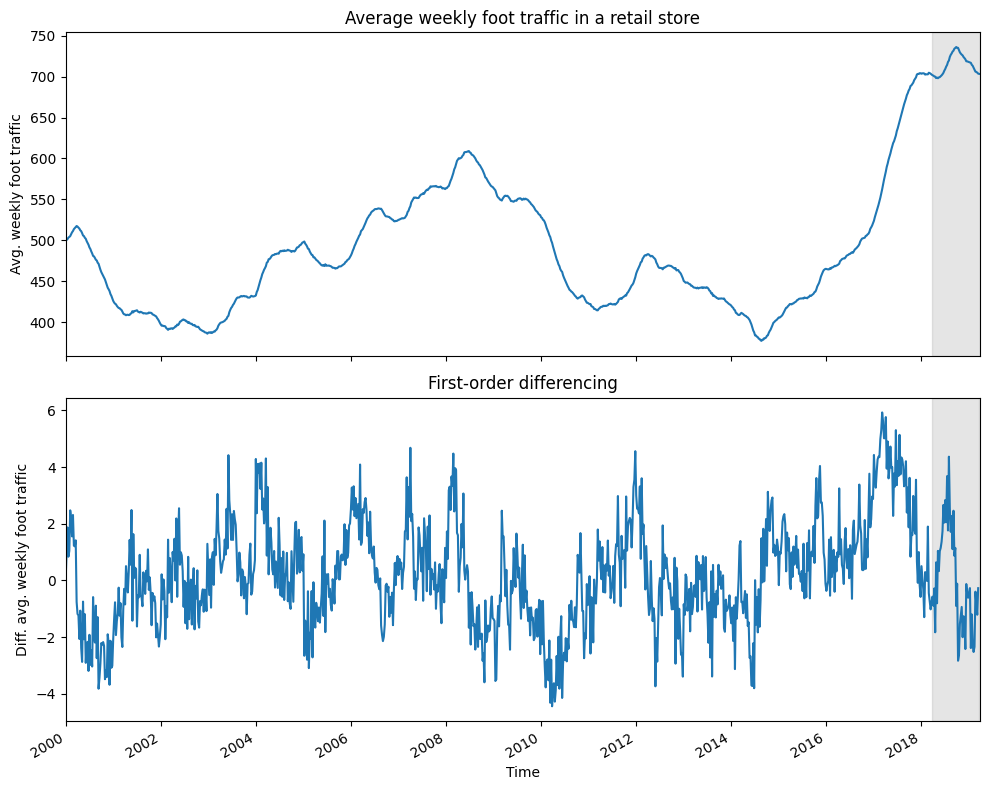

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)
ax1.set_xlim(0, 1000) 
ax1.set_title('Average weekly foot traffic in a retail store')

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)
ax2.set_xlim(0, 1000)
ax2.set_title('First-order differencing')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))  # <==== The order specifies an AR(3) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [33]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1  # <==== Since we wish to predict the next timestep, our window is 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


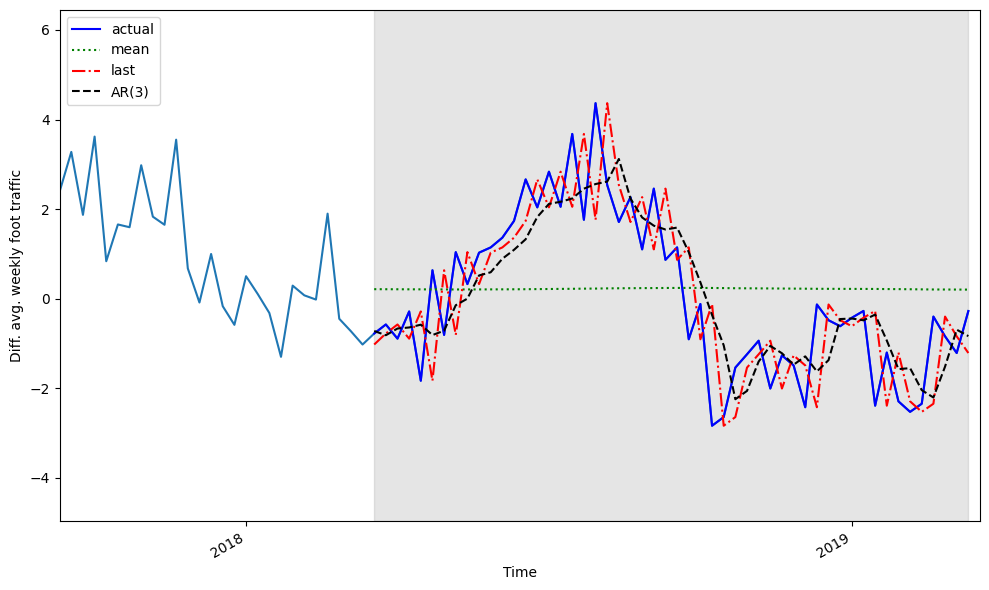

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

*Forecasts of the differenced average weekly foot traffic in a retail store.*

In [36]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean:.2f}')
print(f'MSE (Last Value Forecast): {mse_last:.2f}')
print(f'     MSE (MA(2) Forecast): {mse_AR:.2f}')

      MSE (Mean Forecast): 3.11
MSE (Last Value Forecast): 1.45
     MSE (MA(2) Forecast): 0.92


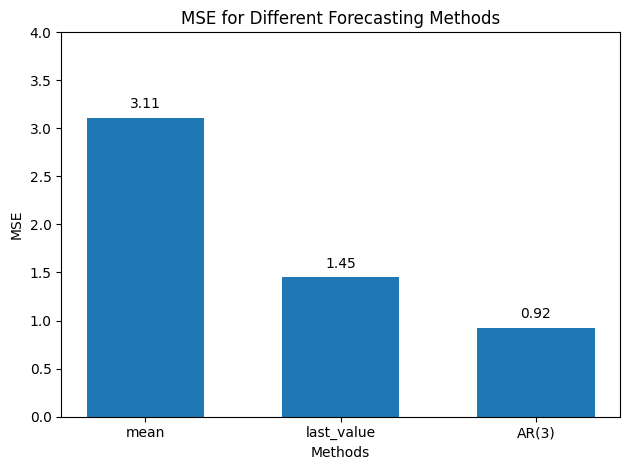

In [37]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [38]:
df['pred_foot_traffic'] = pd.Series()

# Assign the undifferenced predictions to the pred_foot_traffic column in df
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

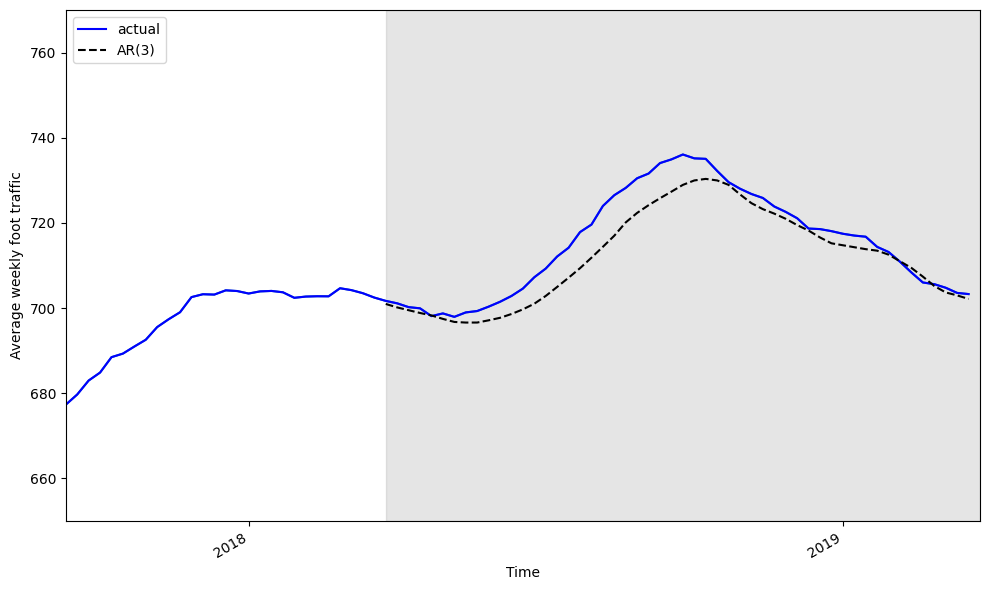

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

*Undifferenced forecasts from the AR(3) model.*

In [41]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print("Mean Absolute Error:",mae_AR_undiff.round(2))

Mean Absolute Error: 3.48
